In [1]:
%matplotlib inline
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from scipy.stats import mode
from utils import RESULTS_ROOT

In [2]:
def merge_array(tril, triu):
    assert tril.shape == triu.shape
    c = np.empty_like(tril)
    c = np.tril(tril, k=-1)
    c += np.triu(triu, k=1)
    return c


def plot_matrix_w_annot(ec, eo, pval_ec=None, pval_eo=None, title=""):
    assert ec.shape == eo.shape
    plt.figure(figsize=(12, 10))

    merged = merge_array(ec, eo)
    mask = np.eye(ec.shape[0], dtype=bool)
    if pval_ec is not None and pval_eo is not None:
        merged_pval = merge_array(pval_ec, pval_eo)
        mask = np.logical_or(merged_pval > 0.05, mask)

    sns.heatmap(
        merged,
        square=True,
        annot=True,
        mask=mask,
        fmt=".2f",
        annot_kws={"size": 9},
    )
    for line in np.arange(5, ec.shape[0], 5):
        plt.axhline(line, color="w")
        plt.axvline(line, color="w")
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    _ = plt.yticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=0,
    )
    _ = plt.xticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=90,
    )
    for pos, method in enumerate(["microstates", "PCA", "ICA", "HMM"]):
        plt.text(
            -4, 2.5 + 5 * pos, method, size=20, ha="left", rotation=90, va="center"
        )
        plt.text(2.5 + 5 * pos, 24, method, size=20, ha="center")
    plt.title(title)

## Segmentation

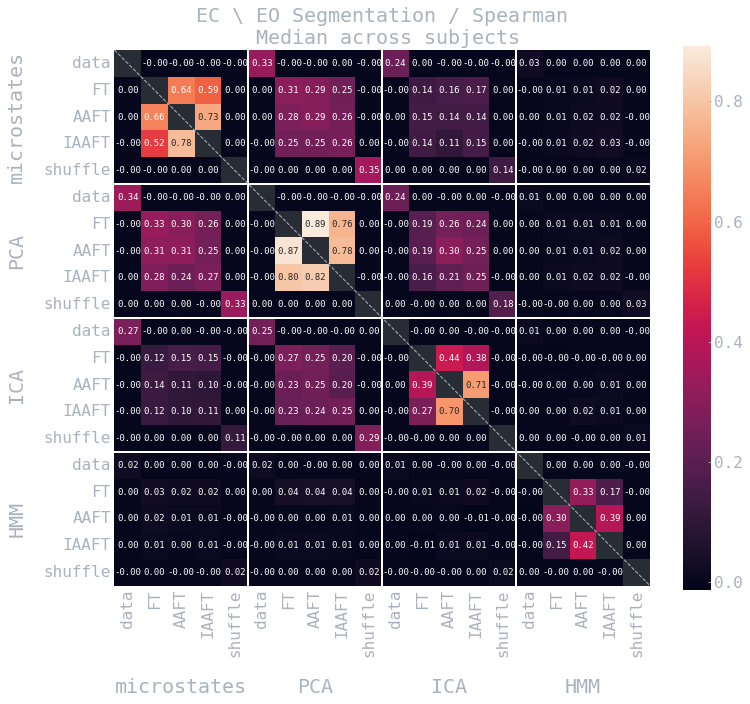

In [11]:
seg_ec = xr.open_dataset(
    os.path.join(RESULTS_ROOT, "aggregated", "segmentation_subjectwise_EC_seeded.nc")
)
seg_eo = xr.open_dataset(
    os.path.join(RESULTS_ROOT, "aggregated", "segmentation_subjectwise_EO_seeded.nc")
)
plot_matrix_w_annot(
    seg_ec["spearman"].median("subject").sel({"value": "measure"}),
    seg_eo["spearman"].median("subject").sel({"value": "measure"}),
    np.squeeze(mode(seg_ec["spearman"].sel({"value": "p-value"}).values)[0]),
    np.squeeze(mode(seg_eo["spearman"].sel({"value": "p-value"}).values)[0]),
    title=r"EC \ EO Segmentation / Spearman" + "\n Median across subjects",
)

## Group topomaps

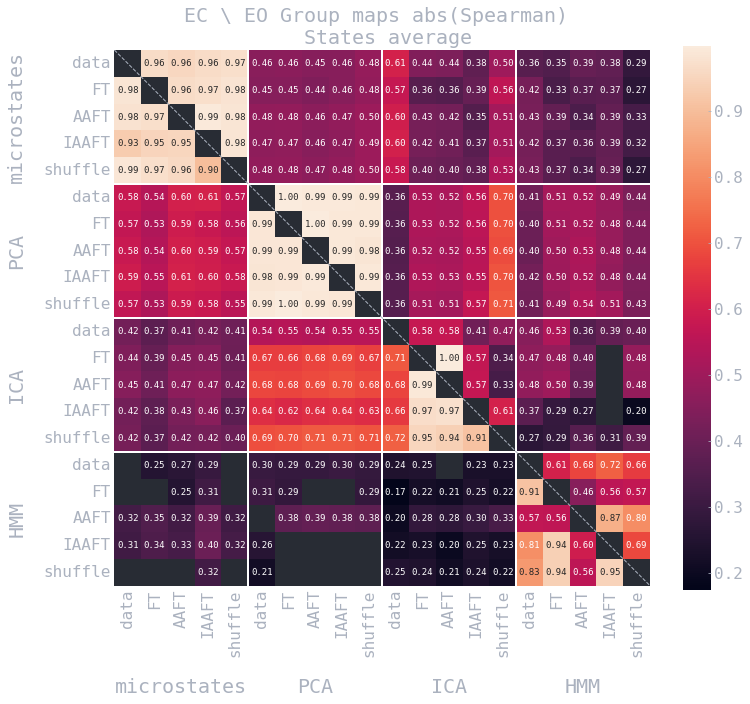

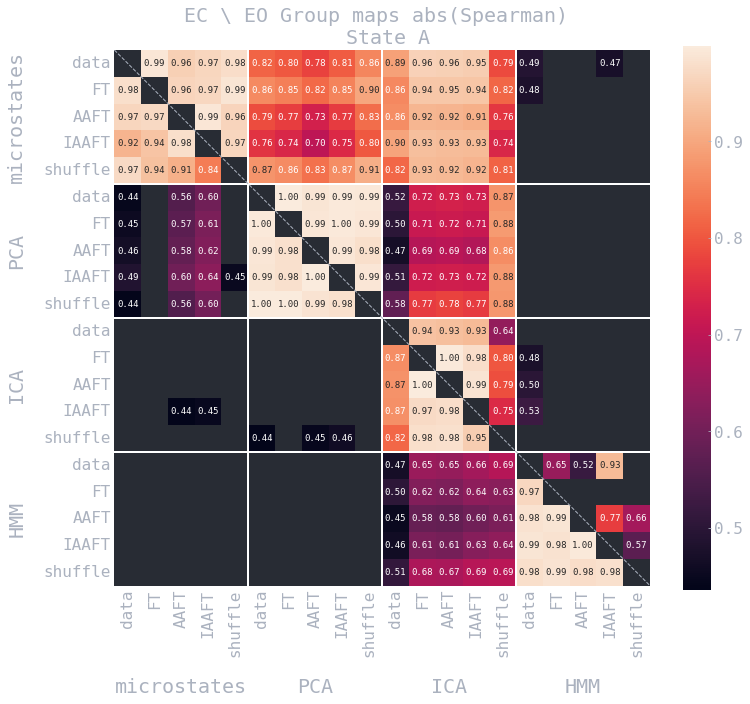

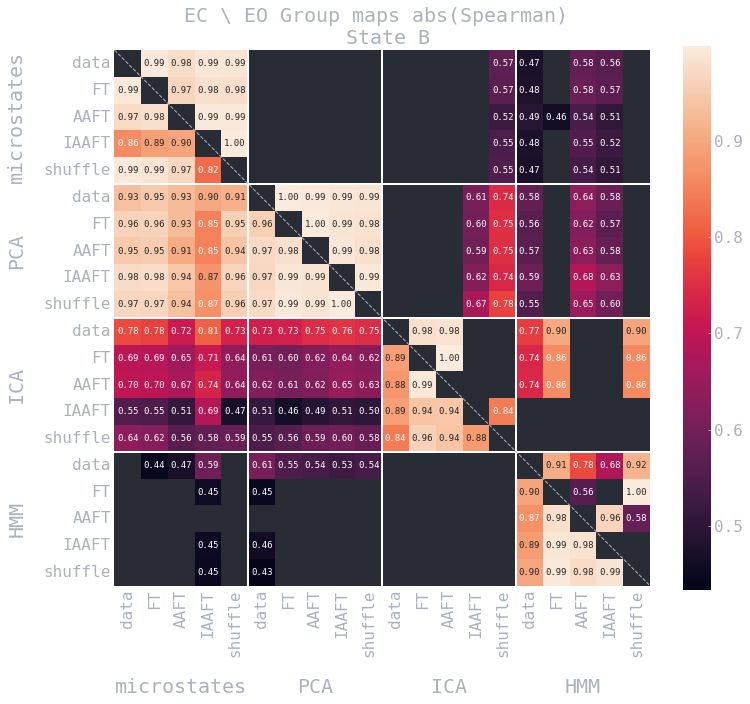

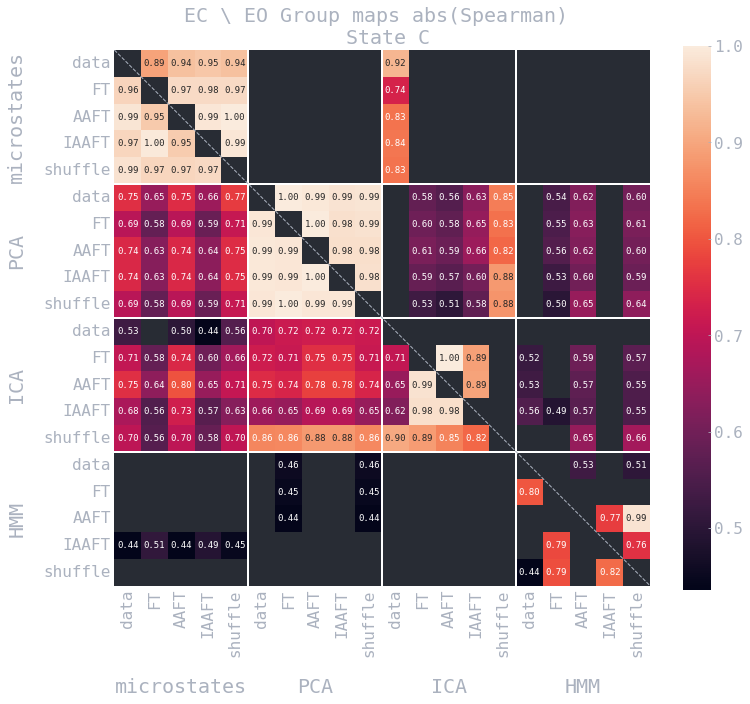

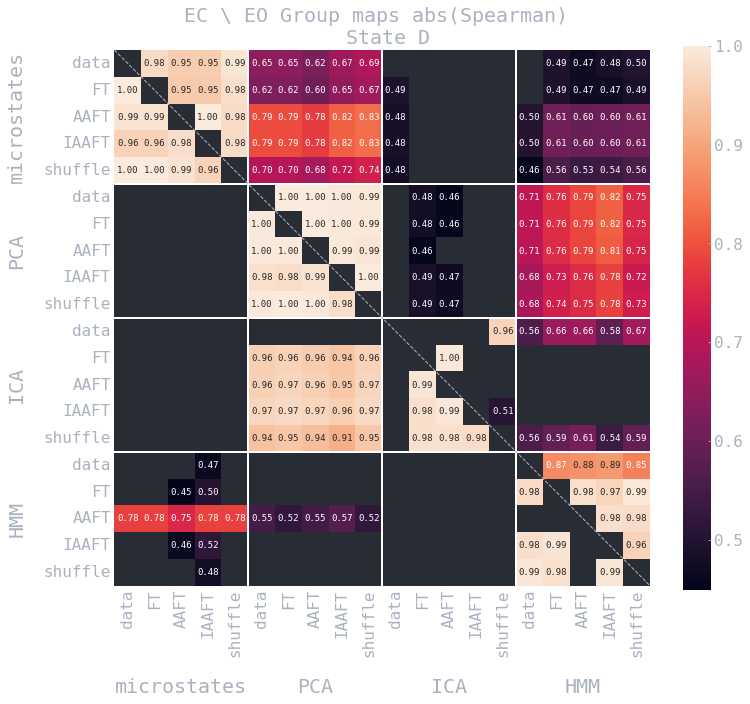

In [4]:
gmaps_ec = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "group_topomaps_EC_seeded.nc")
)
gmaps_eo = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "group_topomaps_EO_seeded.nc")
)
plot_matrix_w_annot(
    gmaps_ec.mean("state").sel({"value": "measure"}),
    gmaps_eo.mean("state").sel({"value": "measure"}),
    np.squeeze(mode(gmaps_ec.sel({"value": "p-value"}).values)[0]),
    np.squeeze(mode(gmaps_eo.sel({"value": "p-value"}).values)[0]),
    title="EC \ EO Group maps abs(Spearman) \n States average",
)

for state in ["A", "B", "C", "D"]:
    plot_matrix_w_annot(
        gmaps_ec.sel({"value": "measure", "state": state}),
        gmaps_eo.sel({"value": "measure", "state": state}),
        gmaps_ec.sel({"value": "p-value", "state": state}),
        gmaps_eo.sel({"value": "p-value", "state": state}),
        title=f"EC \ EO Group maps abs(Spearman) \n State {state}",
    )

## Subject maps

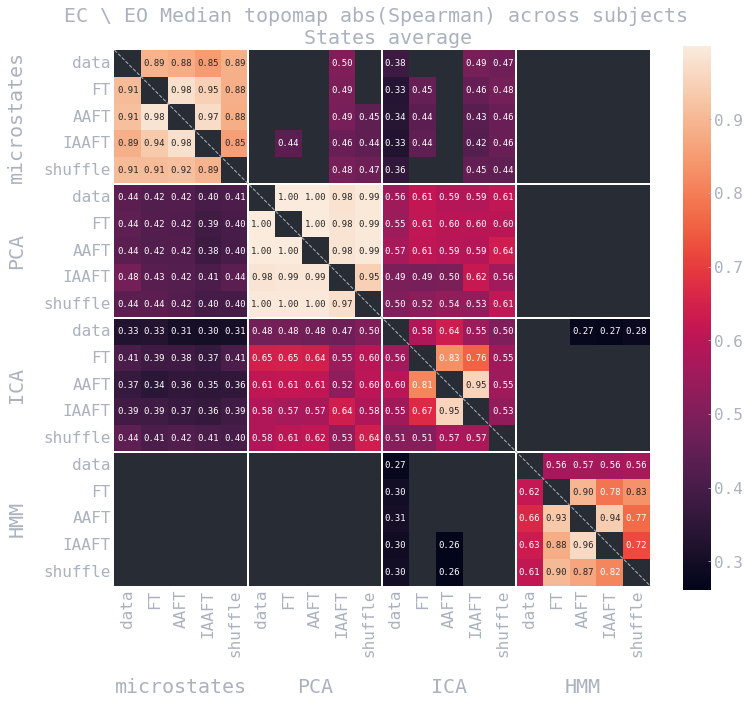

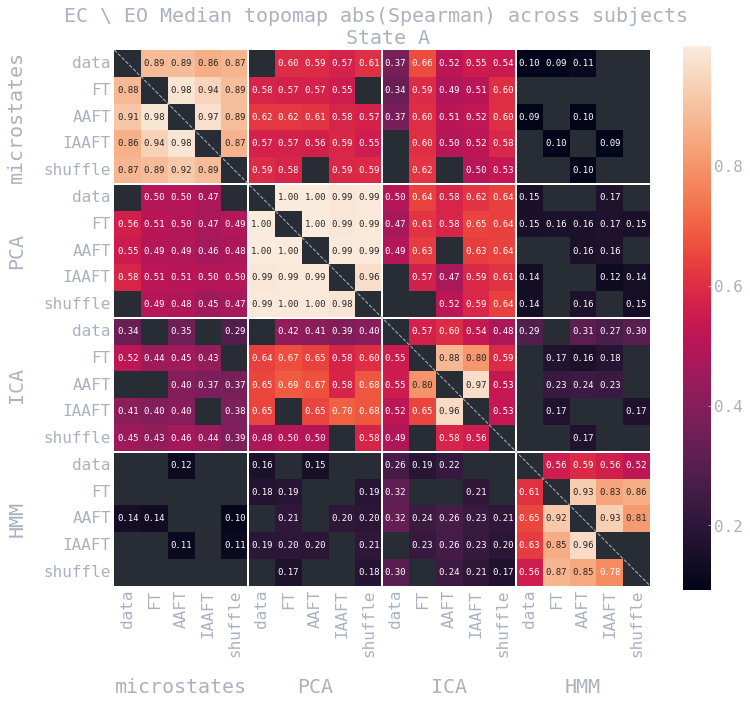

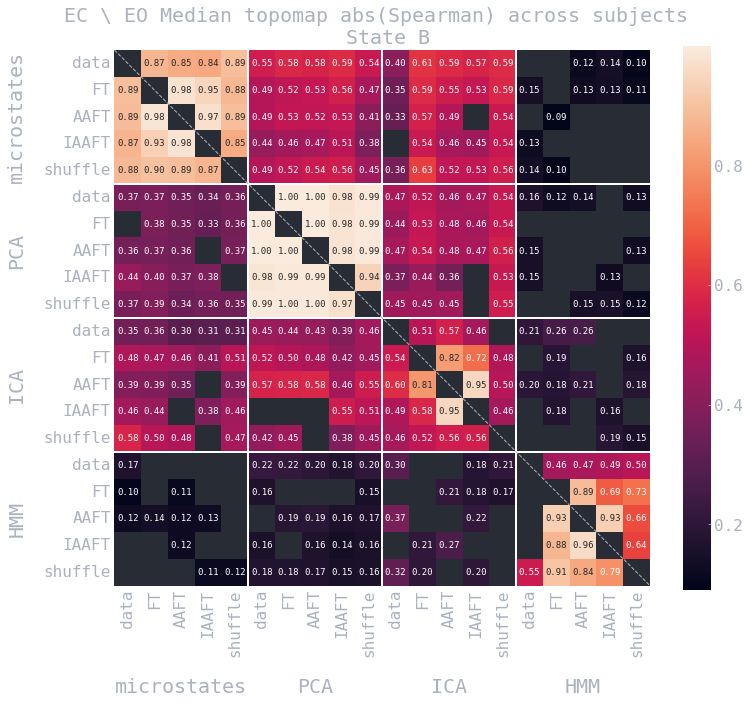

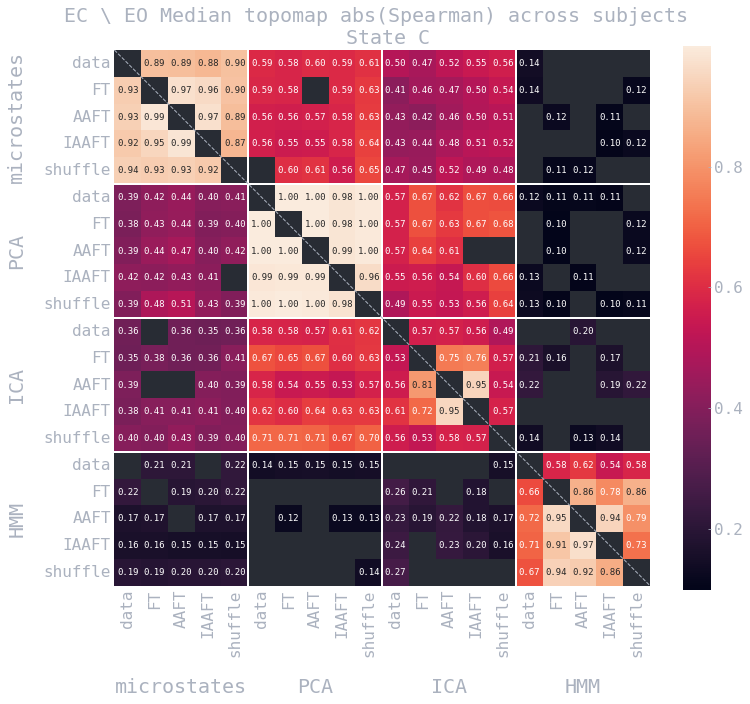

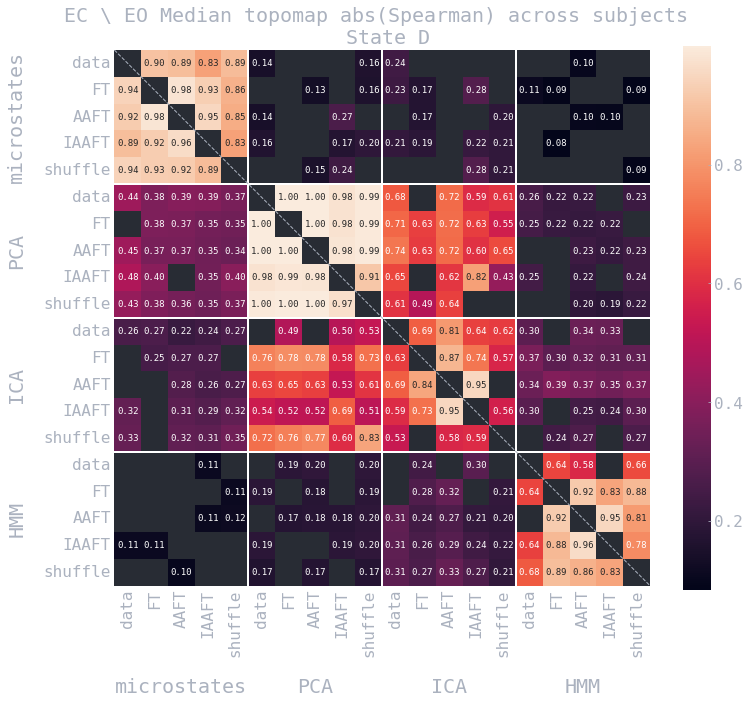

In [5]:
smaps_ec = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "subject_topomaps_EC_seeded.nc")
)
smaps_eo = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "subject_topomaps_EO_seeded.nc")
)
plot_matrix_w_annot(
    smaps_ec.median("subject").mean("state").sel({"value": "measure"}),
    smaps_eo.median("subject").mean("state").sel({"value": "measure"}),
    smaps_ec.median("subject").mean("state").sel({"value": "p-value"}),
    smaps_eo.median("subject").mean("state").sel({"value": "p-value"}),
    title="EC \ EO Median topomap abs(Spearman) across subjects \n States average",
)

for state in ["A", "B", "C", "D"]:
    plot_matrix_w_annot(
        smaps_ec.median("subject").sel({"value": "measure", "state": state}),
        smaps_eo.median("subject").sel({"value": "measure", "state": state}),
        np.squeeze(mode(smaps_ec.sel({"value": "p-value", "state": state}).values, axis=2)[0]),
        np.squeeze(mode(smaps_eo.sel({"value": "p-value", "state": state}).values, axis=2)[0]),
        title=f"EC \ EO Median topomap abs(Spearman) across subjects \n State {state}",
    )

## State statistics
- coverage, occurrence, lifespan

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


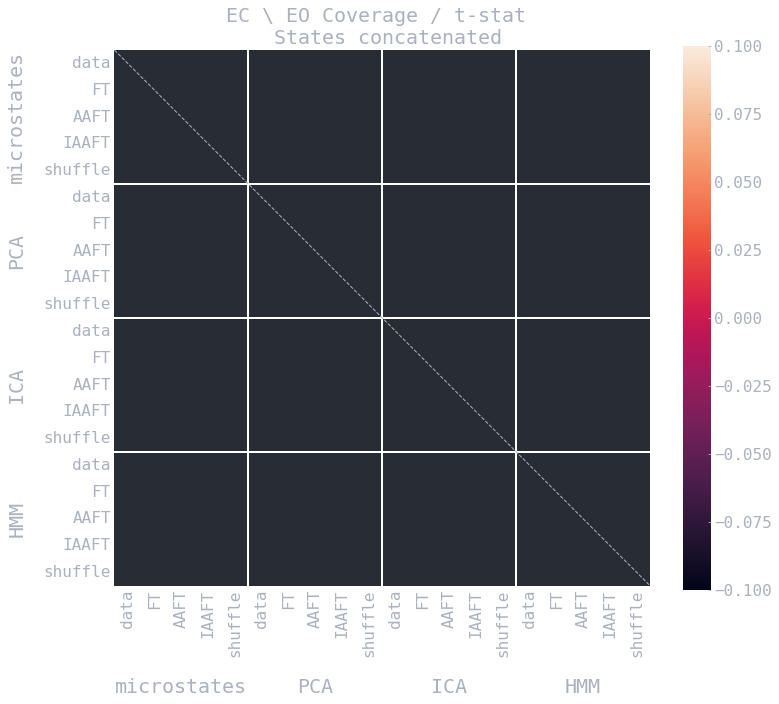

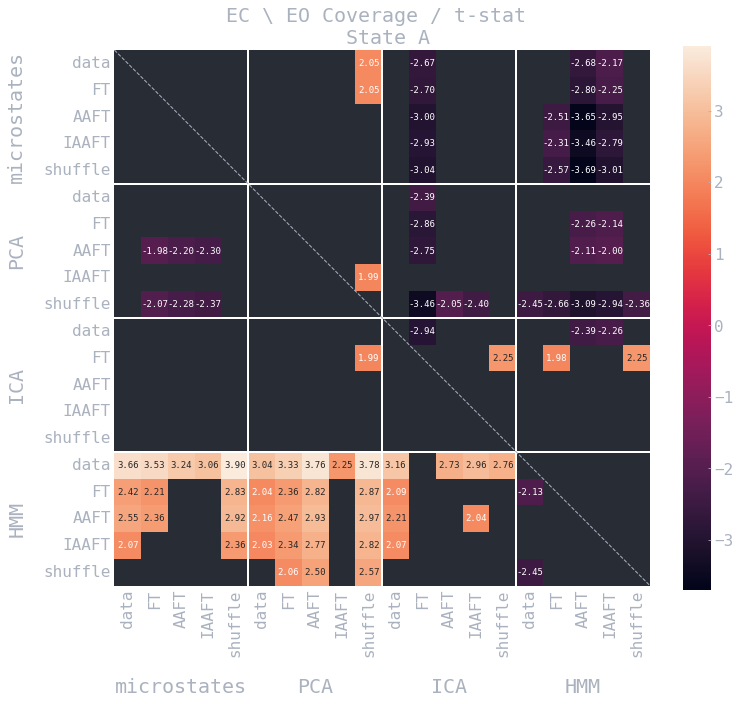

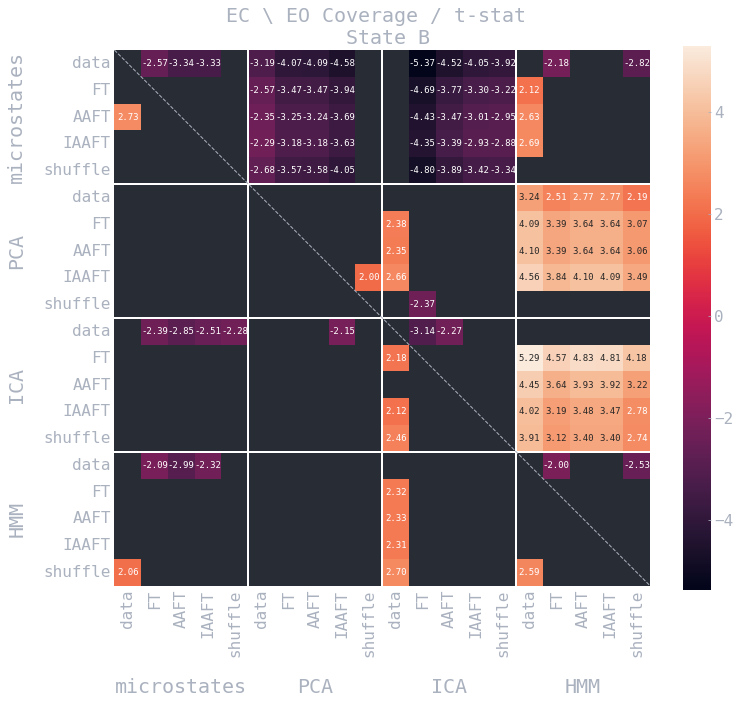

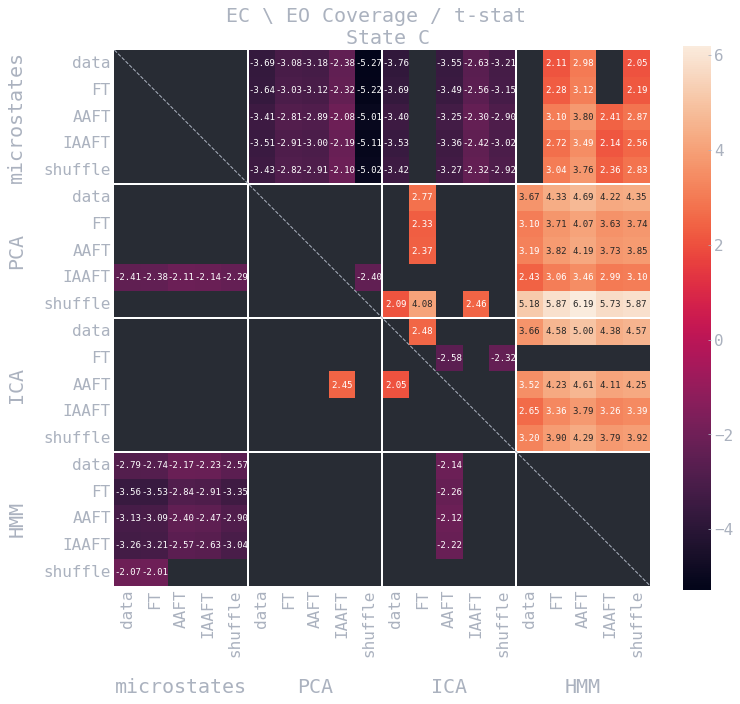

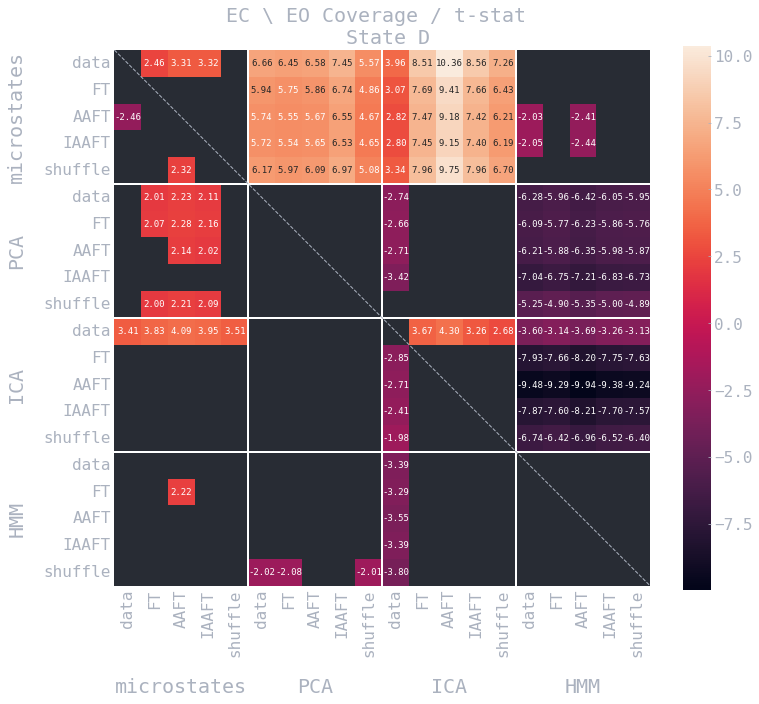

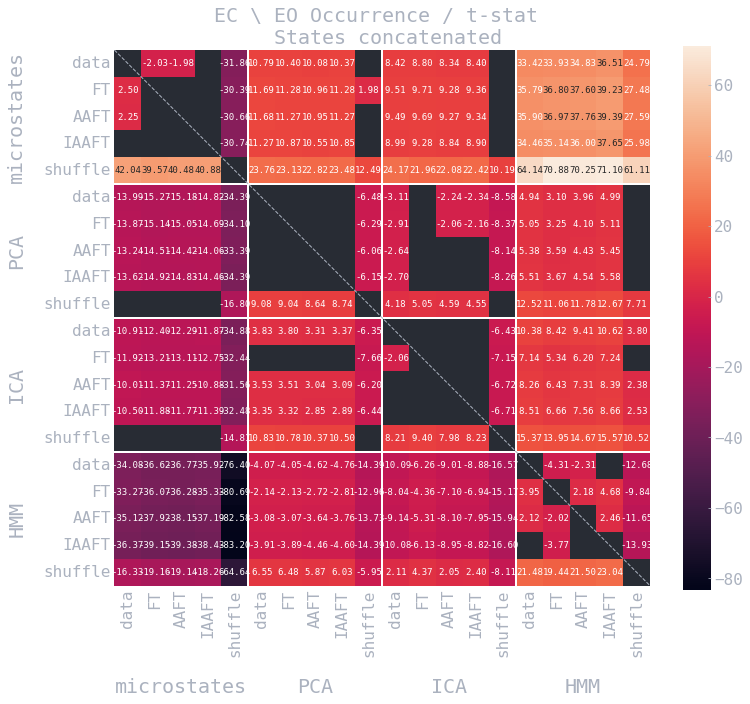

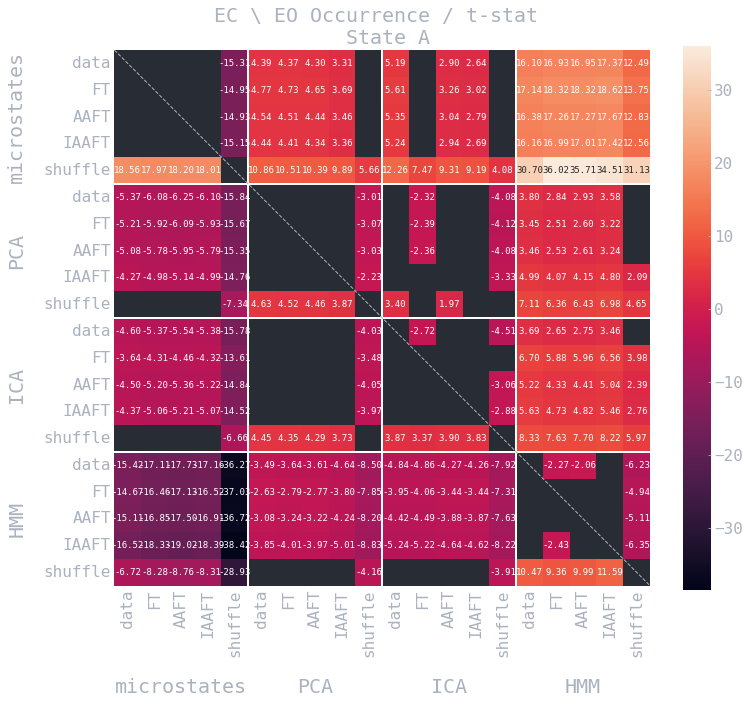

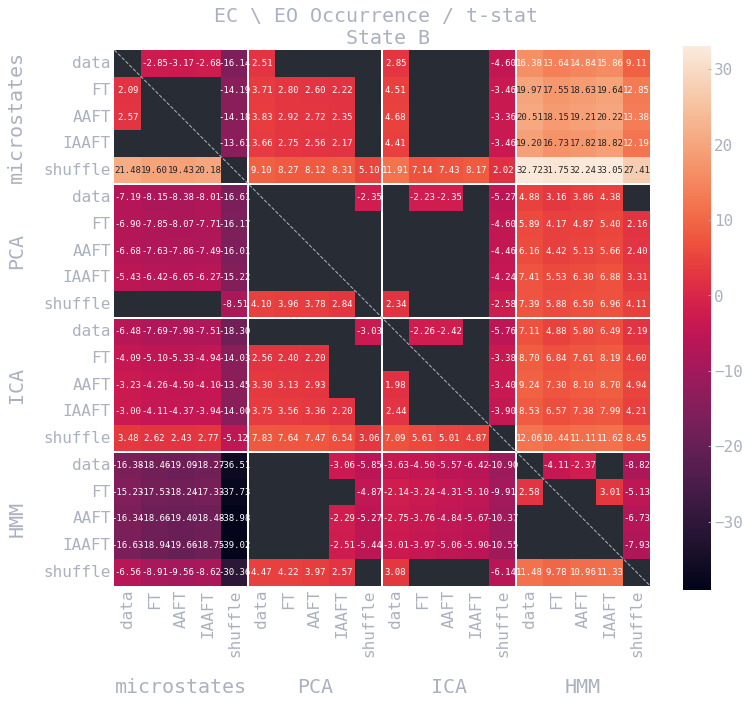

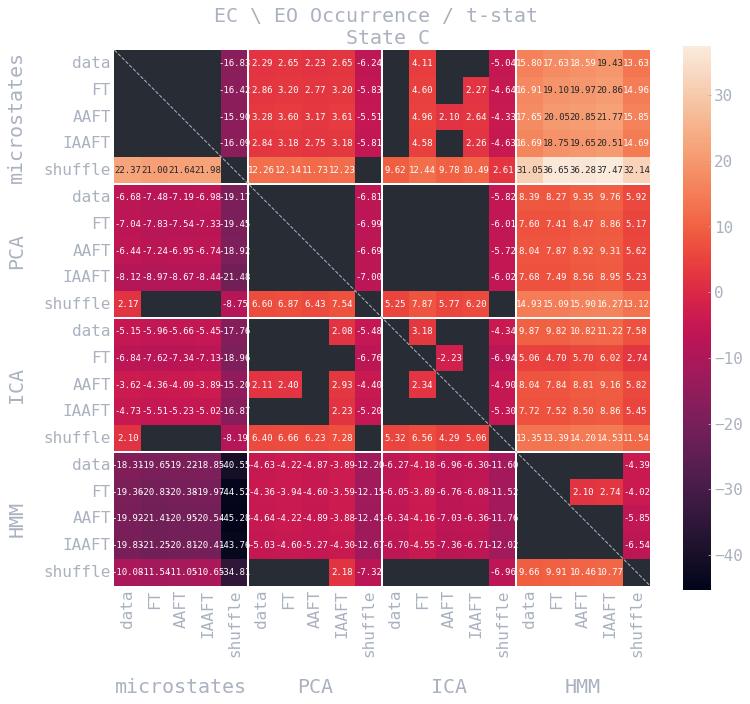

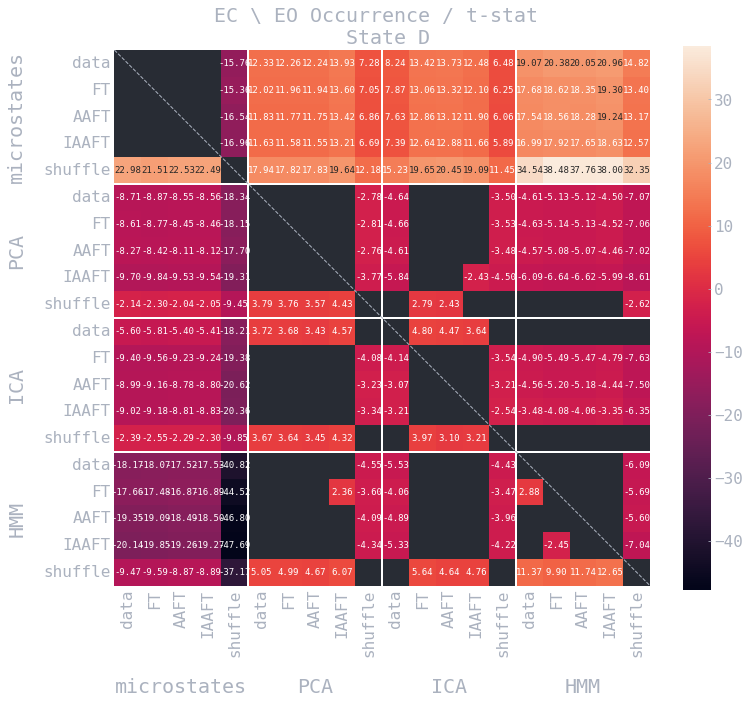

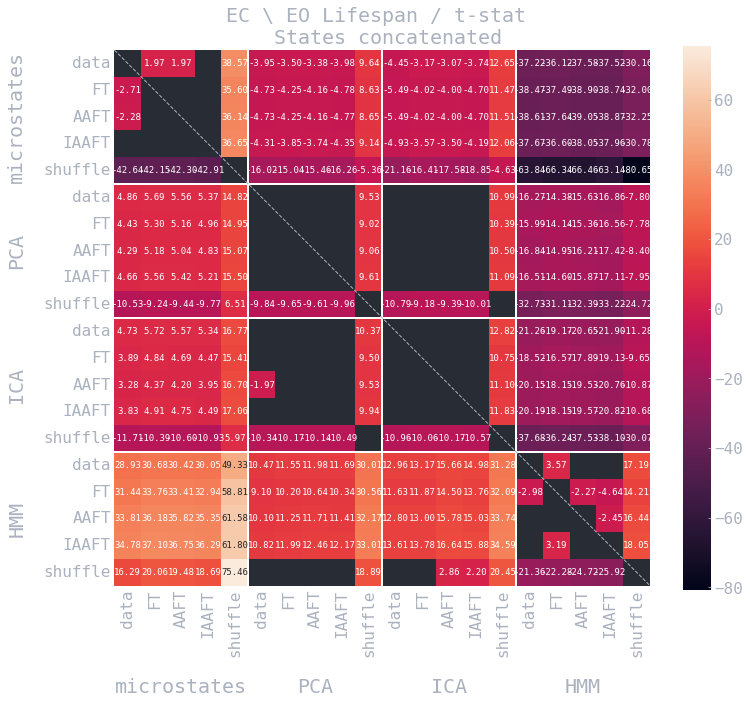

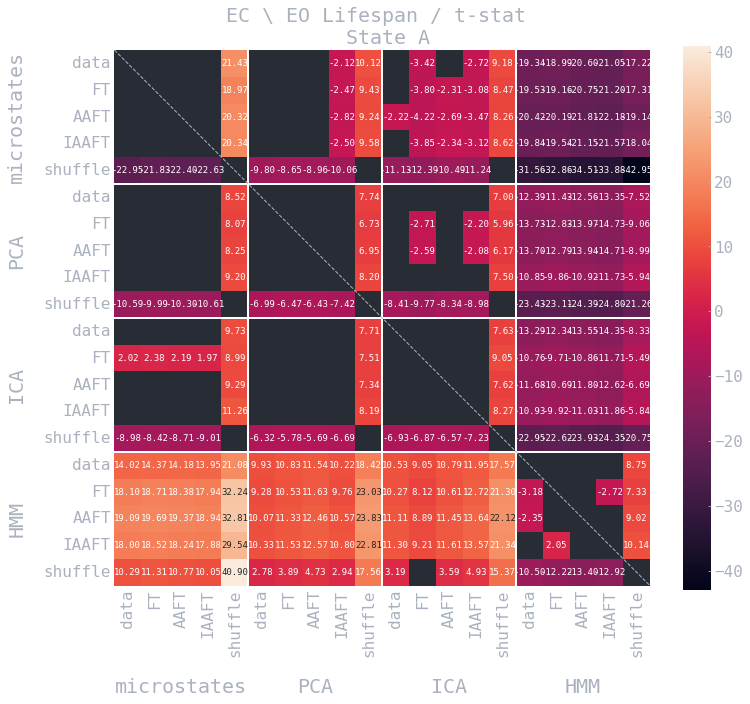

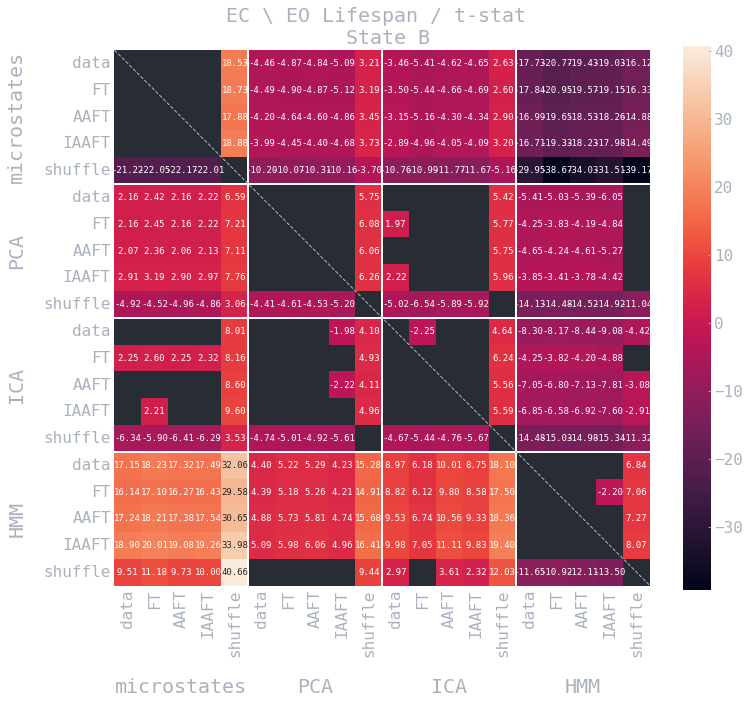

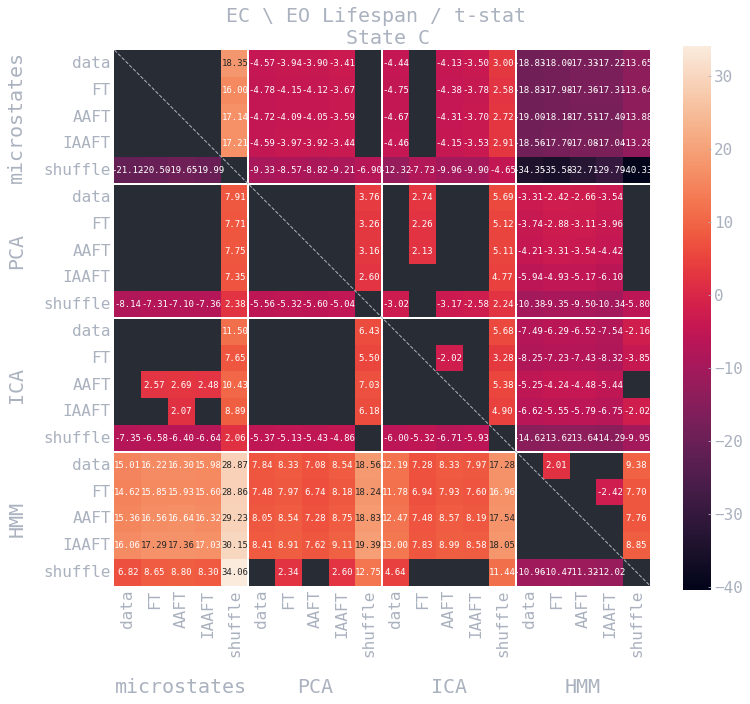

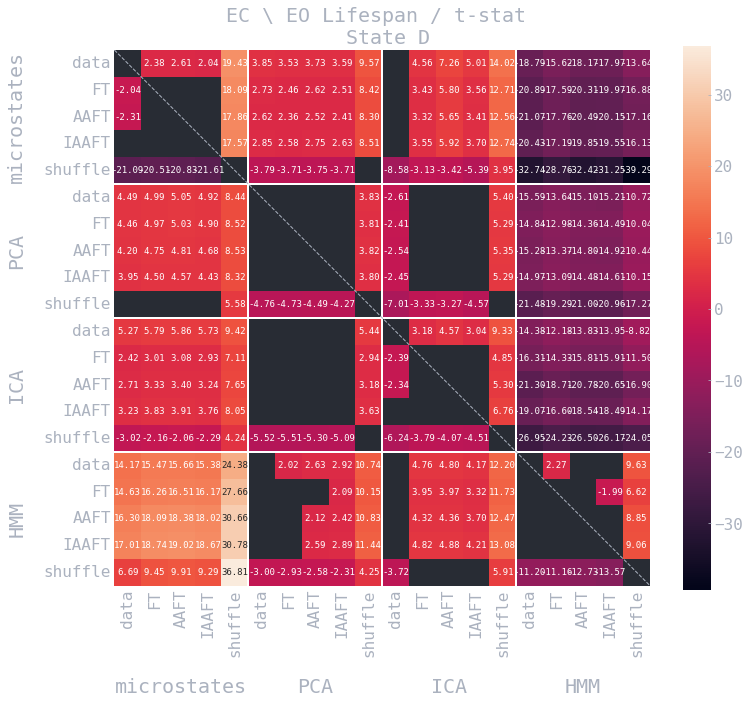

In [6]:
stats_ec = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "state_stats_EC_seeded.nc")
)
stats_eo = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "state_stats_EO_seeded.nc")
)
for var in stats_ec["variable"]:
    for state in stats_ec["state"]:
        if state == "all":
            tit = f"EC \ EO {str(var.values).title()} / t-stat \n States concatenated"
        else:
            tit = f"EC \ EO {str(var.values).title()} / t-stat \n State {state.values}"
        plot_matrix_w_annot(
            stats_ec.sel({"value": "measure", "state": state, "variable": var}),
            stats_eo.sel({"value": "measure", "state": state, "variable": var}),
            stats_ec.sel({"value": "p-value", "state": state, "variable": var}),
            stats_eo.sel({"value": "p-value", "state": state, "variable": var}),
            title=tit,
        )

## Transition matrix statistics

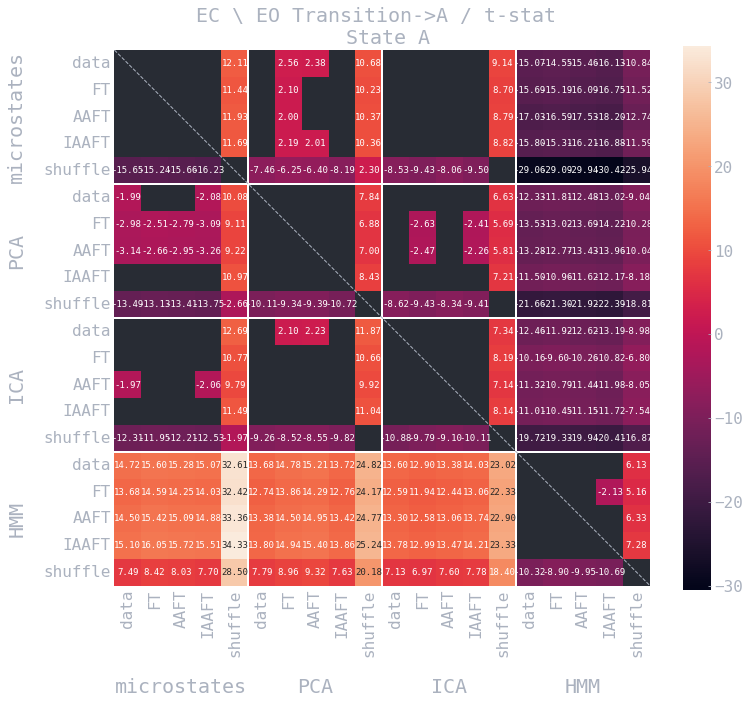

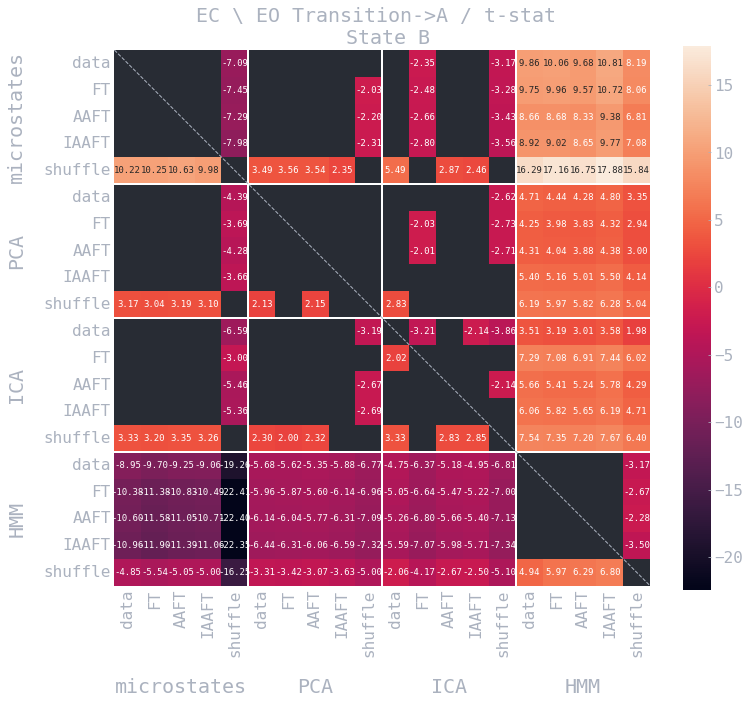

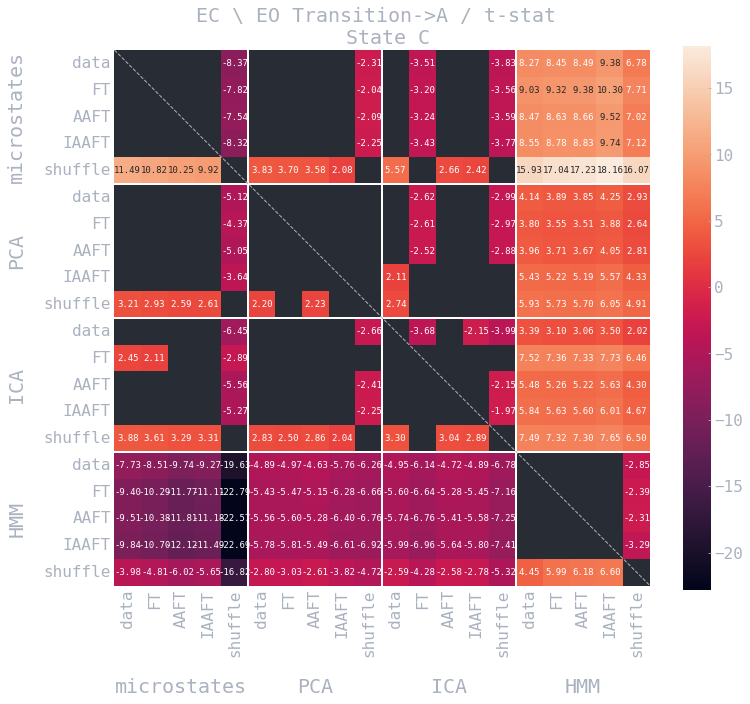

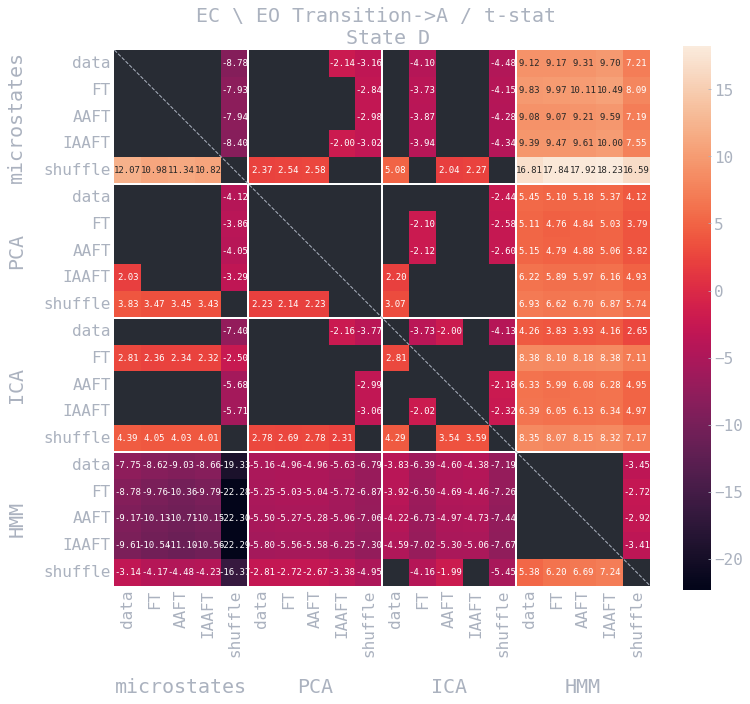

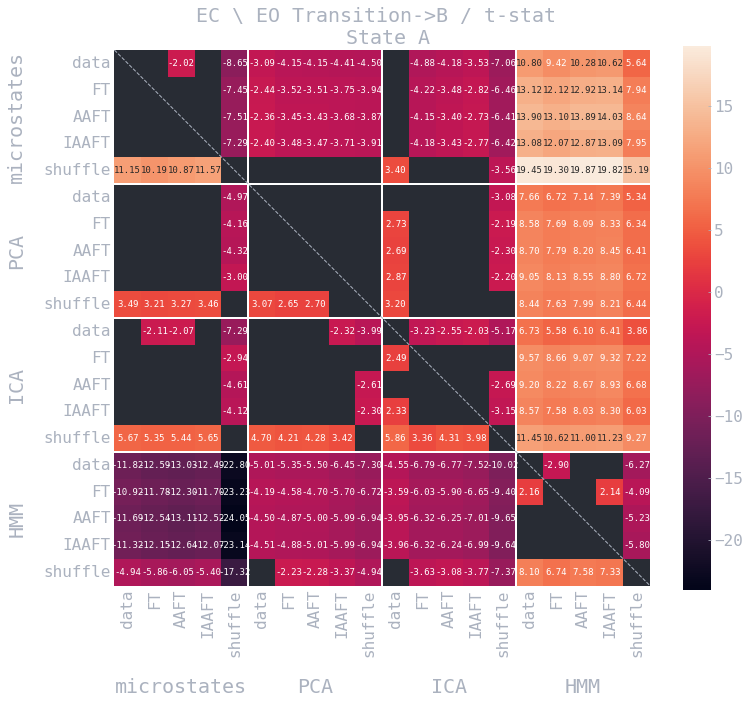

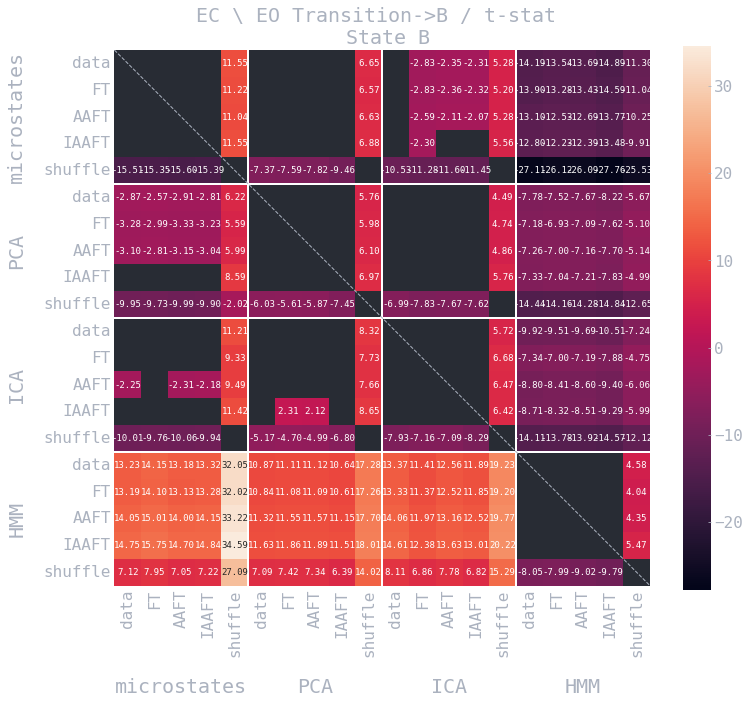

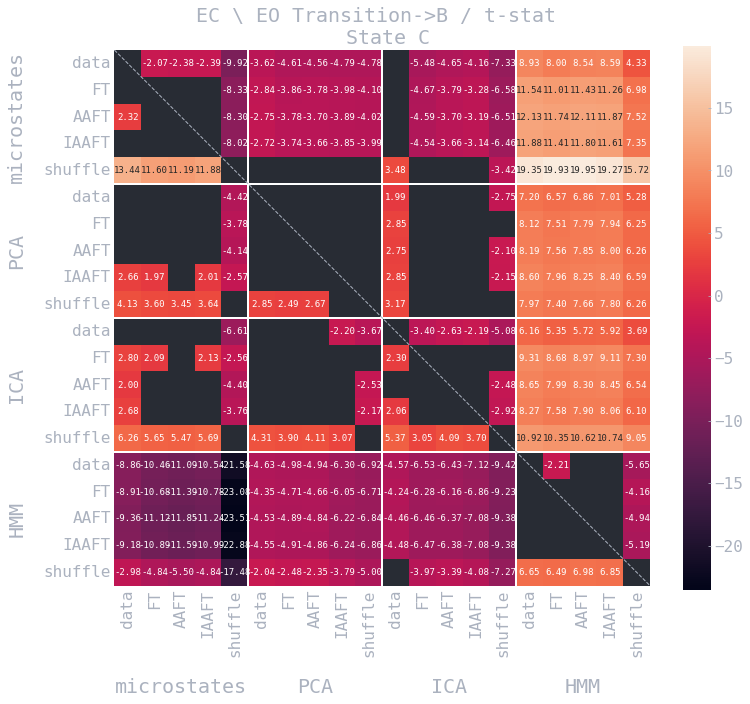

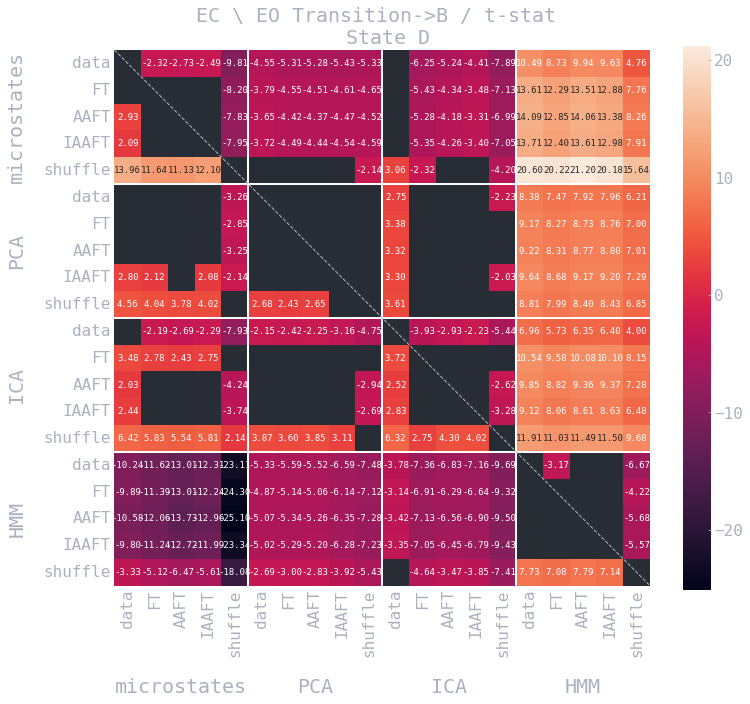

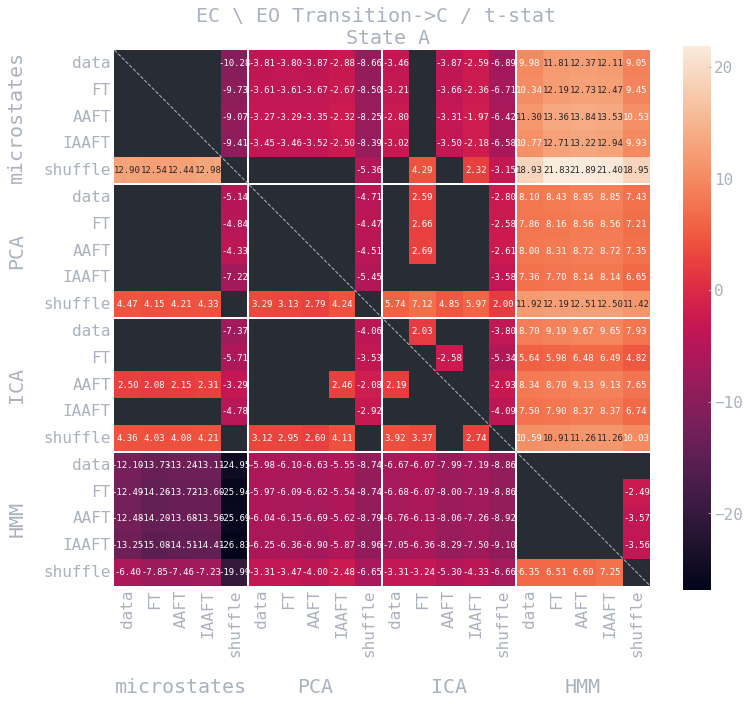

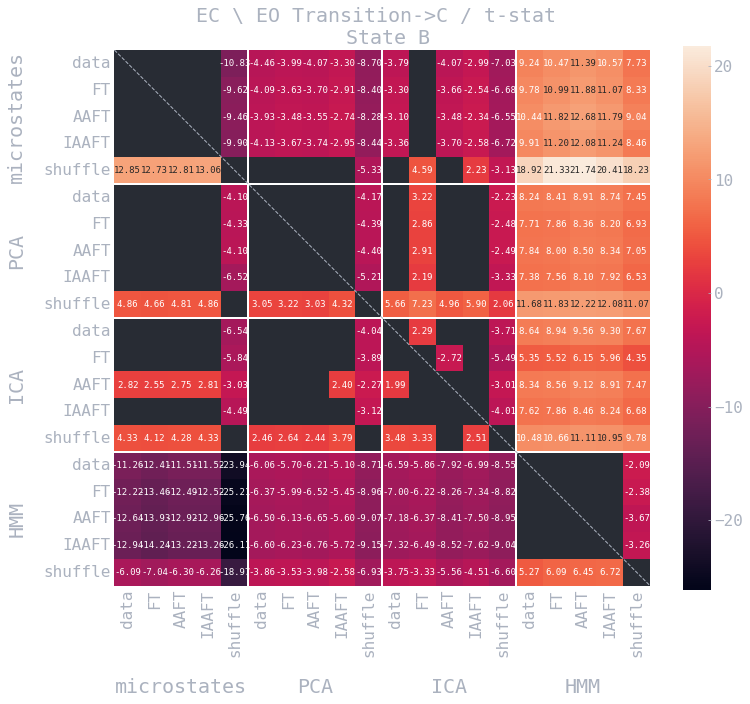

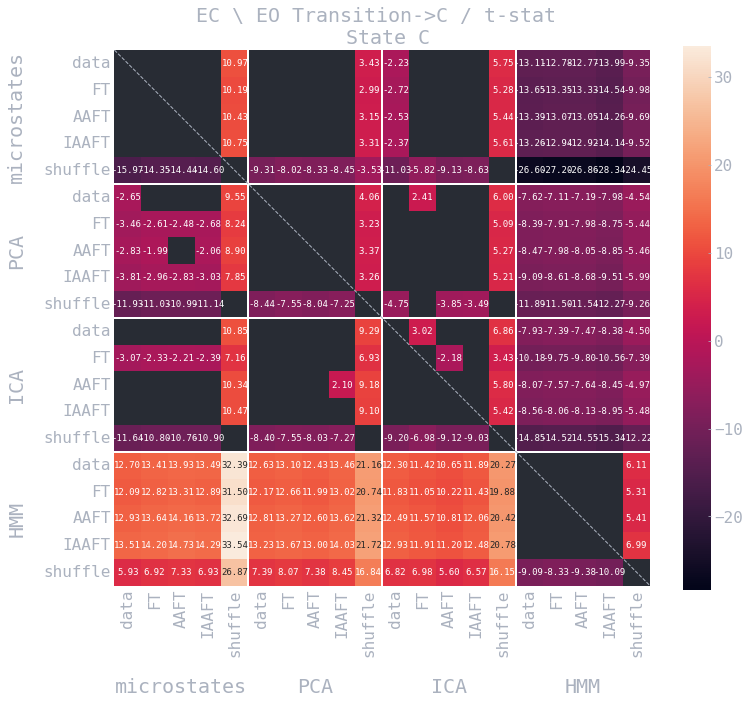

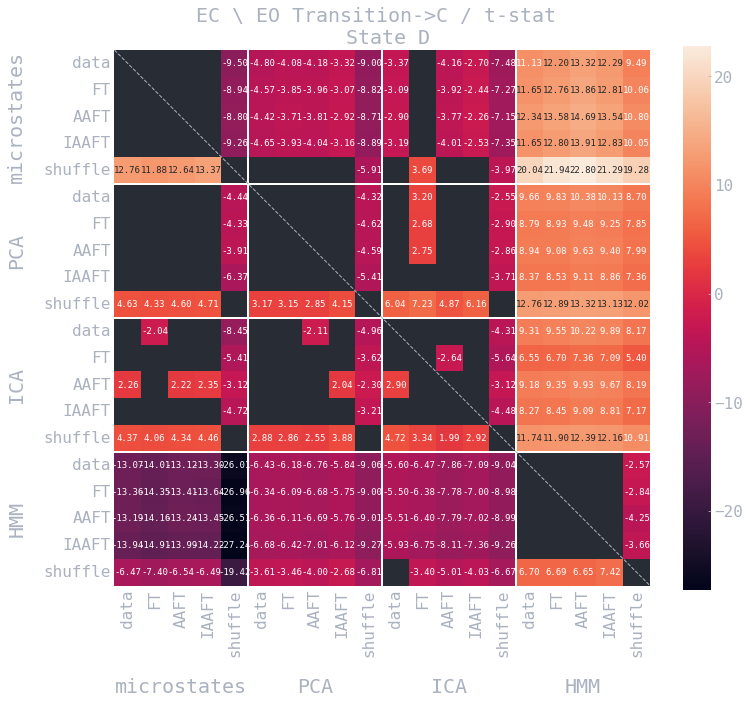

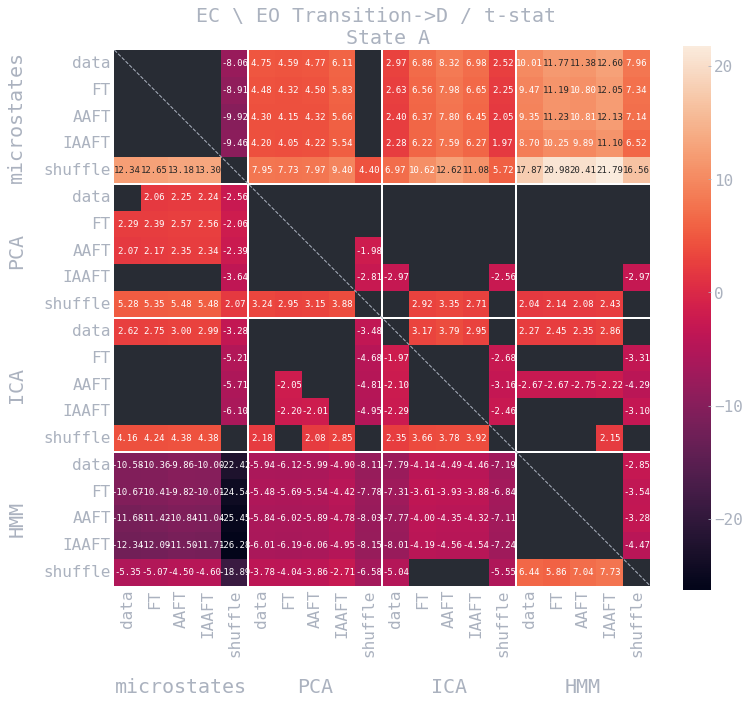

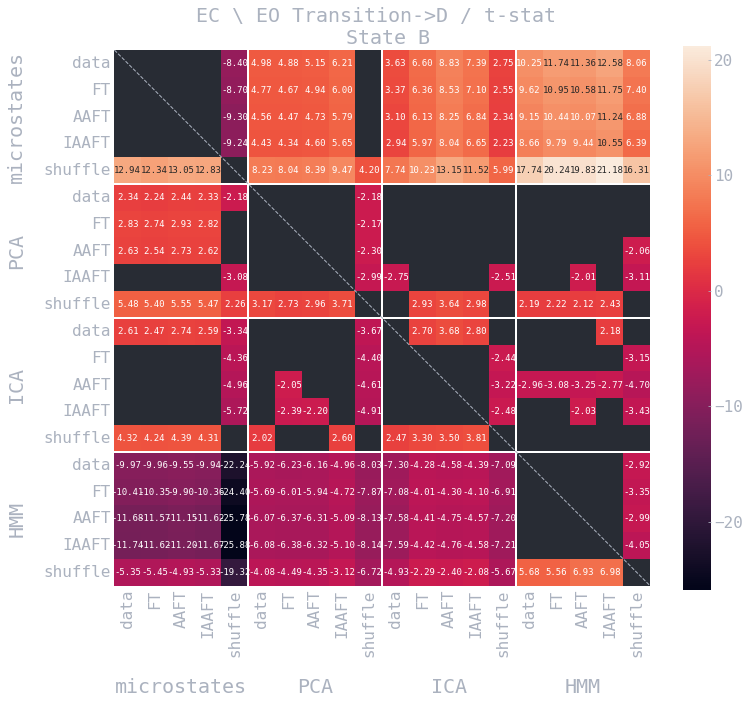

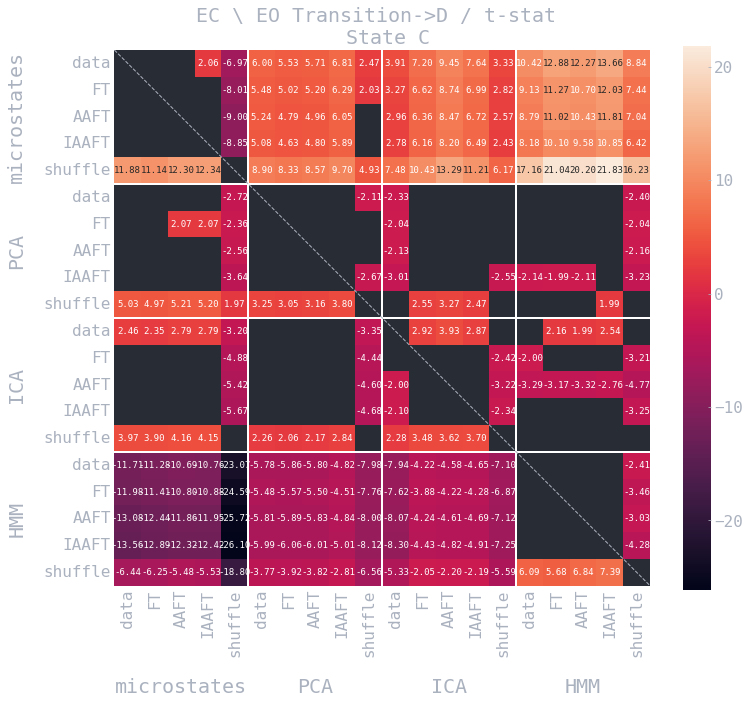

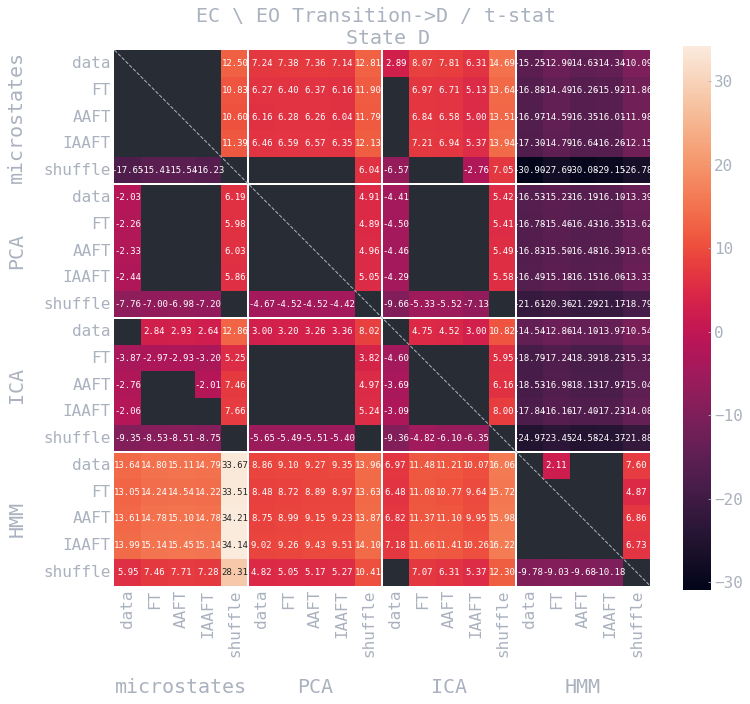

In [7]:
transmat_ec = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "state_transmat_ttest_EC_seeded.nc")
)
transmat_eo = xr.open_dataarray(
    os.path.join(RESULTS_ROOT, "aggregated", "state_transmat_ttest_EO_seeded.nc")
)
for var in transmat_ec["variable"]:
    for state in transmat_ec["state"]:
        plot_matrix_w_annot(
            transmat_ec.sel({"value": "measure", "state": state, "variable": var}),
            transmat_eo.sel({"value": "measure", "state": state, "variable": var}),
            transmat_ec.sel({"value": "p-value", "state": state, "variable": var}),
            transmat_eo.sel({"value": "p-value", "state": state, "variable": var}),
            title=f"EC \ EO {str(var.values).title()} / t-stat \n State {state.values}",
        )